<h1>Import</h1>

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
from PIL import Image
import numpy as np
from tensorflow.keras.layers import Conv2D,Dense,GRU, Dropout, Activation, Flatten, TimeDistributed
from tensorflow.keras.layers import RepeatVector,Bidirectional,BatchNormalization,MaxPool2D
import os

<h1>Explore Data</h1>

In [59]:
data_root = pathlib.Path('./words_captcha')
    
all_paths = list(data_root.glob('*.*'))

all_image_paths = all_paths
all_image_paths = shuffle(all_image_paths, random_state=1)

image_count = len(all_image_paths)
print(txt_path)
print('\ntotal img num:', image_count)


words_captcha/a125065.png

total img num: 140001


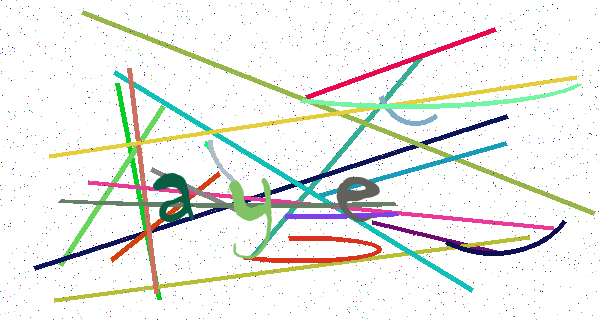

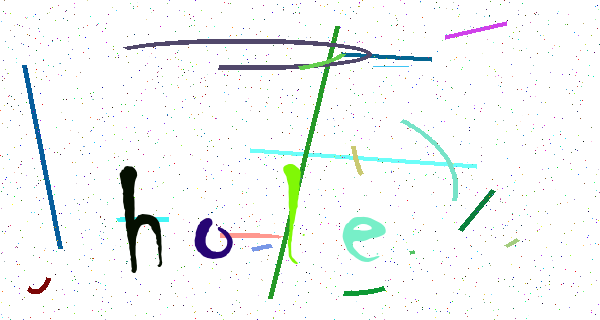

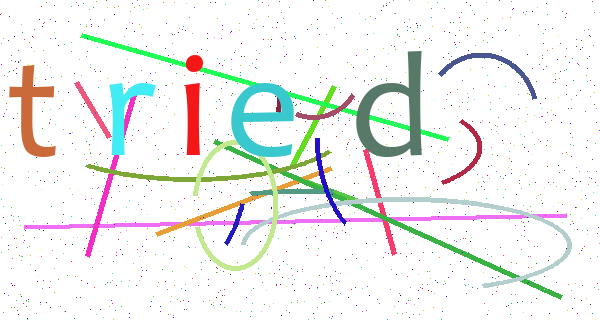

In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(Image.open(str(image_path)))

In [5]:
captcha_image = Image.open(all_image_paths[100])
captcha_image = np.array(captcha_image)
print(captcha_image.shape)

(320, 600, 3)


<h1>Parameter</h1>

In [6]:
IMAGE_HEIGHT = 80
IMAGE_WIDTH = 150
image_shape = (3,80,150)
max_caption_len = 5
images_dir = "words_captcha"
labels_dir = "./words_captcha/spec_train_val.txt"
model_output = "./checkpoints/"

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z','.']
vocab_size = len(alphabet)

<h1>Prepare Dataset</h1>

In [8]:
# loda images
def load_image(image_path, label):
    path = 'words_captcha/' + image_path +'.png' 
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)    
    return img, label

In [9]:
# get labels
img_name,img_label = list(),list()
for line in open(labels_dir):
    line=line.strip('\n')
    img_name.append(line.split(' ')[0])
    img_label.append(line.split(' ')[1])

In [10]:
# preprocess labels
label_categorical=list()
for i in range(0,120000):
    temp=list()
    label = img_label[i]
    if len(label)<5:
        label=label+'.'*(5-len(label))
    for j in range(5):
        temp.append(tf.keras.utils.to_categorical(alphabet.index(label[j]), 27,dtype=int))
    temp = np.asarray(temp)
    label_categorical.append(temp)
    
labels_categorical= np.asarray(label_categorical)
print("input labels shape", labels_categorical.shape)

input labels shape (120000, 5, 27)


In [11]:
# partition dataset
img_path_train = img_name[0:100000]
label_train = labels_categorical[0:100000]
img_path_val = img_name[100000:120000]
label_val = labels_categorical[100000:120000]

In [12]:
# get image path
img_path_test = list()
for idx in range(120000,140000):
    path = 'a'+str(idx)
    img_path_test.append(path)

In [0]:
# prepare dataset for trainig
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)



In [0]:
# parse training data
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,3])

    return image, label

In [0]:
# Construct training Dataset
dataset_train = dataset_train.map(map_fun)
dataset_train = dataset_train.shuffle(10000)
dataset_train = dataset_train.batch(64)

# # Construct valid Dataset
dataset_val = dataset_val.map(map_fun)
dataset_val = dataset_val.batch(64)



<h1>Build Model</h1>

In [13]:
image_model = tf.keras.Sequential()
#CNN layer 1
image_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(80, 150, 3)))
image_model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
image_model.add(BatchNormalization())
#CNN layer 2
image_model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
image_model.add(BatchNormalization())
image_model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
image_model.add(Dropout(0.25))
#CNN layer 3
image_model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
image_model.add(BatchNormalization())
image_model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
image_model.add(Activation('relu'))
#CNN layer 4
image_model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
image_model.add(BatchNormalization())
image_model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
image_model.add(Dropout(0.25))
image_model.add(Flatten())
# RNN
image_model.add(Dense(128))
image_model.add(RepeatVector(max_caption_len))
image_model.add(Bidirectional(GRU(units=128, return_sequences=True)))
image_model.add(TimeDistributed(Dense(vocab_size)))
image_model.add(Activation('softmax'))

In [14]:
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 150, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 75, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 75, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 75, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 38, 32)        0

<h1>Training</h1>

In [0]:
EPOCHS = 80

# Checkpoint path and its name
CKP_DIR_SAVE_CALLBACKS = 'checkpoints_save_callbacks/ckpt-{epoch}.ckpt'
checkpoint_dir = os.path.dirname(CKP_DIR_SAVE_CALLBACKS)


sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
image_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CKP_DIR_SAVE_CALLBACKS, 
    verbose=1, 
    save_weights_only=True,
    save_freq=100000)

# Train the model with the new callback
history = image_model.fit(dataset_train, 
          epochs=EPOCHS, 
          callbacks=[cp_callback],
          validation_data=dataset_val)



Epoch 1/81
   1562/Unknown - 276s 177ms/step - loss: 0.3164 - accuracy: 0.9109
Epoch 00001: saving model to /content/drive/My Drive/checkpoints_save_callbacks/ckpt-39.ckpt
1563/1563 [==============================] - 326s 209ms/step - loss: 0.3164 - accuracy: 0.9109 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/81
1562/1563 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.9124
Epoch 00002: saving model to /content/drive/My Drive/checkpoints_save_callbacks/ckpt-39.ckpt
1563/1563 [==============================] - 338s 216ms/step - loss: 0.3121 - accuracy: 0.9124 - val_loss: 0.3355 - val_accuracy: 0.9113
Epoch 3/81
1561/1563 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.9134
Epoch 00003: saving model to /content/drive/My Drive/checkpoints_save_callbacks/ckpt-39.ckpt
1563/1563 [==============================] - 350s 224ms/step - loss: 0.3074 - accuracy: 0.9134 - val_loss: 0.2133 - val_accuracy: 0.9452
Epoch 4/81
1562/1563 [=====

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

<h1>Output</h1>

In [47]:
def decode(prediction):
    ans_str=''
    for vector in prediction:
        for word in vector:
            index =np.argmax(word)
            if index == 26:
                return ans_str
            else:
                ans_str=ans_str+alphabet[index]
    return ans_str

In [57]:
image_model.load_weights('img_caption_ckpt/ckpt-39.ckpt')
with open("Lab13-2_108065531.txt","w") as fp:
    for idx in range(len(img_path_test)):
        path = 'words_captcha/' + img_path_test[idx] +'.png'
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        img = tf.cast(img, tf.float32)
        img = tf.reshape(img,[1,IMAGE_HEIGHT,IMAGE_WIDTH,3])
        #print(img.shape)
        predict = image_model.predict(img)
        ans = decode(predict)
        fp.write(img_path_test[idx]+' '+ans+'\n')
